# Libraries

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import random
import time
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize

#import lightgbm as lgb
import xgboost as xgb
#import catboost as ctb
#from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'loss'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 17
    CVSEED = 17
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 10000
    EARLY_STOPPING_ROUNDS = 200
    VERBOSE = 1000
    SEED = 17
    CVSEED = 17
    #N_ITERS = 10

In [3]:
def set_seed(seed=17):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-aug-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")


# Preprocessing

In [5]:
scale_features = [col for col in test.columns if 'f' in col]

ss = StandardScaler()
train[scale_features] = ss.fit_transform(train[scale_features])
test[scale_features] = ss.transform(test[scale_features])


In [6]:
# Swap noise

# Random
def apply_noise_rn(df, p=.75):
    should_not_swap = np.random.binomial(1, p, df.shape)
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Row-wise
def apply_noise_row(df, p=.75):
    should_not_swap = np.zeros(df.shape)
    for i in range(df.shape[0]):
        for j in np.random.choice(df.shape[1],int(p*df.shape[1]),replace=False):
            should_not_swap[i,j]=1 
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df
    

# Pseudo Label

In [7]:
pseudo = pd.read_csv("../input/tps-aug-2021-lgbm-xgb-catboost/submission.csv")[target]
test_pseudo = pd.concat([test, pseudo], axis=1)
all_pseudo = pd.concat([train, test_pseudo]).reset_index(drop=True)

# XGB

In [8]:
xgb_params = {
    'objective': 'reg:squarederror',    
    'seed': SEED,   
    'n_estimators': N_ESTIMATORS,
    'importance_type': 'total_gain',
    'tree_method': 'gpu_hist',    
    
    'learning_rate': 0.004456183434811274, 
    'subsample': 0.7193486774183349, 
    'colsample_bytree': 0.4976929879139919,
    'max_depth': 16, 
    'lambda': 11.052431489457067,
    'alpha': 25.908000014344125, 
    'min_child_weight': 342.6638701552546
}


In [9]:
xgb_oof = np.zeros(train.shape[0])
xgb_pred = np.zeros(test.shape[0])
xgb_importances = pd.DataFrame()


kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED, SEED+1, SEED+2]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=all_pseudo[scale_features], y=all_pseudo[target])):
    print(f"===== fold {fold} =====")
    
    oof_idx = np.array([idx for idx in val_idx if idx < train.shape[0]])
    preds_idx = np.array([idx for idx in val_idx if idx >= train.shape[0]])
    
    X_train, y_train = all_pseudo[scale_features].iloc[trn_idx], all_pseudo[target].iloc[trn_idx]
    #X_train = apply_noise_row(X_train)
    
    X_valid, y_valid = all_pseudo[scale_features].iloc[oof_idx], all_pseudo[target].iloc[oof_idx]
    X_test = all_pseudo[scale_features].iloc[preds_idx]
    
    

    # XGB       
    start = time.time()
    
    for inseed in seed_list:
        xgb_params['seed'] = inseed
        
        pre_model = xgb.XGBRegressor(**xgb_params)
        pre_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='rmse',
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            verbose=VERBOSE
        )


        xgb_params2 = xgb_params.copy()
        xgb_params2['lambda'] *= 0.9
        xgb_params2['alpha'] *= 0.9
        xgb_params2['learning_rate'] *= 0.1
        model = xgb.XGBRegressor(**xgb_params2)
        model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='rmse',
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
                xgb_model=pre_model
        )    

        with open(f"xgb_model{fold}.pkl", 'wb') as f:
            pickle.dump(model, f)

        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = X_train.columns
        fi_tmp['importance'] = model.feature_importances_
        fi_tmp['fold'] = fold
        fi_tmp['seed'] = inseed
        xgb_importances = xgb_importances.append(fi_tmp)

        xgb_oof[oof_idx] += model.predict(X_valid) / len(seed_list)
        xgb_pred[preds_idx-train.shape[0]] += model.predict(X_test) / len(seed_list)

    elapsed = time.time() - start
    rmse = mean_squared_error(y_valid, xgb_oof[oof_idx], squared=False)
    print(f"fold {fold} - xgb rmse: {rmse:.6f}, elapsed time: {elapsed:.2f}sec\n")

    
        
print(f"oof xgb_rmse = {mean_squared_error(train[target], xgb_oof, squared=False)}")

np.save("xgb_oof.npy", xgb_oof)
np.save("xgb_pred.npy", xgb_pred)


===== fold 0 =====
[0]	validation_0-rmse:10.08962
[1000]	validation_0-rmse:7.80255
[2000]	validation_0-rmse:7.78396
[3000]	validation_0-rmse:7.77621
[4000]	validation_0-rmse:7.77165
[5000]	validation_0-rmse:7.76917
[6000]	validation_0-rmse:7.76754
[6915]	validation_0-rmse:7.76657
[0]	validation_0-rmse:7.76660
[596]	validation_0-rmse:7.76652
[0]	validation_0-rmse:10.08957
[1000]	validation_0-rmse:7.80309
[2000]	validation_0-rmse:7.78462
[3000]	validation_0-rmse:7.77710
[4000]	validation_0-rmse:7.77329
[5000]	validation_0-rmse:7.77110
[6000]	validation_0-rmse:7.76987
[6662]	validation_0-rmse:7.76958
[0]	validation_0-rmse:7.76958
[1000]	validation_0-rmse:7.76945
[1200]	validation_0-rmse:7.76947
[0]	validation_0-rmse:10.08955
[1000]	validation_0-rmse:7.80172
[2000]	validation_0-rmse:7.78292
[3000]	validation_0-rmse:7.77514
[4000]	validation_0-rmse:7.77095
[5000]	validation_0-rmse:7.76898
[6000]	validation_0-rmse:7.76699
[6163]	validation_0-rmse:7.76699
[0]	validation_0-rmse:7.76699
[592]	v

# OOF predictions

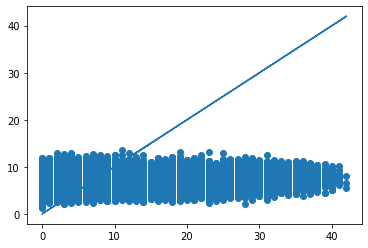

In [10]:
plt.plot(train[target], train[target])
plt.scatter(train[target], xgb_oof)

# Features importances

Text(0.5, 1.0, 'XGBoost feature importances')

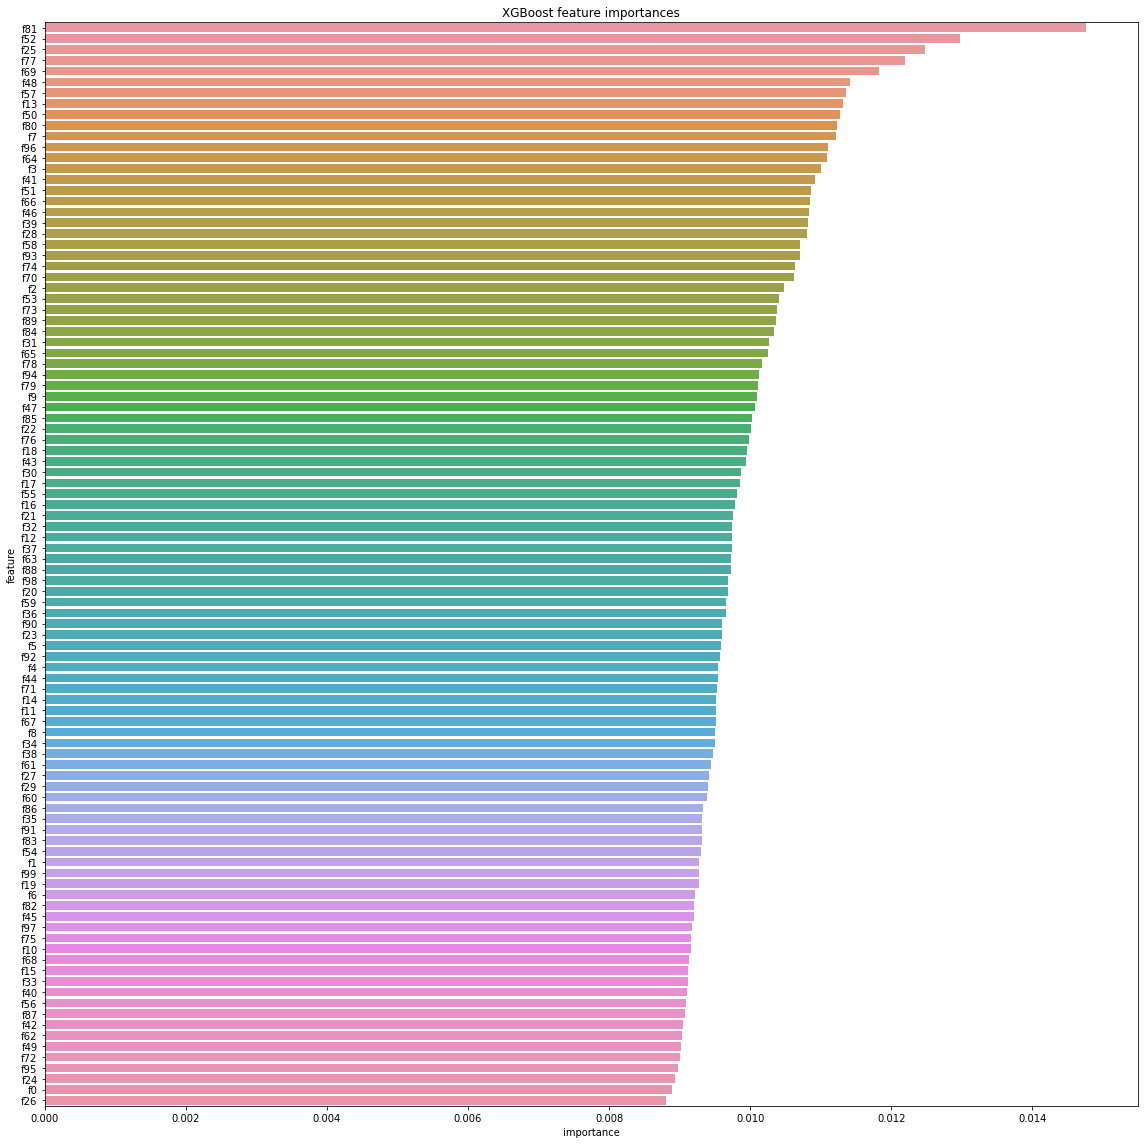

In [11]:
order = list(xgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=xgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("XGBoost feature importances")

# Submission

In [12]:
submission[target] = xgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,loss
0,250000,7.896606
1,250001,5.021981
2,250002,8.782863
3,250003,7.948441
4,250004,6.777964
...,...,...
149995,399995,8.324040
149996,399996,7.624845
149997,399997,6.060772
149998,399998,5.555998
